# [Question 1]
TODO download data and unzip archive file commands

In [1]:
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-04.csv nyc_tlc/trip_data/yellow_tripdata_2018-04.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-05.csv nyc_tlc/trip_data/yellow_tripdata_2018-05.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-06.csv nyc_tlc/trip_data/yellow_tripdata_2018-06.csv
!aws s3 cp s3://nyc-tlc/misc/taxi\ _zone_lookup.csv nyc_tlc/misc/taxi_zone_lookup.csv
!aws s3 cp s3://nyc-tlc/misc/taxi_zones.zip nyc_tlc/misc/taxi_zones.zip
!cd nyc_tlc/misc/ && rm -rf taxi_zones && unzip taxi_zones.zip -d taxi_zones

download: s3://nyc-tlc/trip data/yellow_tripdata_2018-04.csv to nyc_tlc/trip_data/yellow_tripdata_2018-04.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-05.csv to nyc_tlc/trip_data/yellow_tripdata_2018-05.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-06.csv to nyc_tlc/trip_data/yellow_tripdata_2018-06.csv
download: s3://nyc-tlc/misc/taxi _zone_lookup.csv to nyc_tlc/misc/taxi_zone_lookup.csv
download: s3://nyc-tlc/misc/taxi_zones.zip to nyc_tlc/misc/taxi_zones.zip
Archive:  taxi_zones.zip
  inflating: taxi_zones/taxi_zones.prj  
  inflating: taxi_zones/taxi_zones.dbf  
  inflating: taxi_zones/taxi_zones.shp  
  inflating: taxi_zones/taxi_zones.shp.xml  
  inflating: taxi_zones/taxi_zones.shx  
  inflating: taxi_zones/taxi_zones.sbn  
  inflating: taxi_zones/taxi_zones.sbx  


Validate [Question 1], you should get:

```
nyc_tlc
├── misc
│   ├── taxi_zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip_data
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 12 files
```

In [2]:
!tree nyc_tlc

nyc_tlc
├── misc
│   ├── taxi_zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip_data
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 12 files


## Basic Prepare

We import all useful packages, and set the `first_datetime` to 2018-01-01 00:00:00, and `last_datetime` to 2018-07-01 00:00:00. We split the dataset into two parts: train and validate, by setting the `train_valid_split_datetime` to 2018-06-01 00:00:00.

In [3]:
# imports

import time
import pickle
import datetime
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae


import contest_helper

# global setting
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Taxi Zones

Since newest NYC Taxi dataset only provides `PULocationID` and `DOLocationID`, instead of `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`, we can only predict requests in each `PULocationID` (zone). We load [taxi _zone_lookup.csv] and [taxi_zones.shp], and use `geopandas` to visualize the zones in Manhattan (69 in total).

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
manhattan_location_num: 69


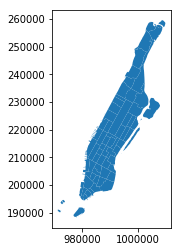

In [4]:
fdt = datetime.datetime.strptime('2018-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')
ldt = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'

nyc_taxi_analyzer = contest_helper.NycTaxiAnalyzer('nyc_tlc/misc/taxi_zone_lookup.csv',
                                                   'nyc_tlc/misc/taxi_zones/taxi_zones.shp',
                                                  first_datetime=fdt, last_datetime=ldt)

train_valid_split_datetime = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'


first_5min_id = nyc_taxi_analyzer.get_5min_id(fdt)
first_15min_id = nyc_taxi_analyzer.get_15min_id(fdt)
first_30min_id = nyc_taxi_analyzer.get_30min_id(fdt)


last_5min_id = nyc_taxi_analyzer.get_5min_id(ldt)
last_15min_id = nyc_taxi_analyzer.get_15min_id(ldt)
last_30min_id = nyc_taxi_analyzer.get_30min_id(ldt)


train_valid_split_5min_id = nyc_taxi_analyzer.get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = nyc_taxi_analyzer.get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = nyc_taxi_analyzer.get_30min_id(train_valid_split_datetime)

nyc_taxi_analyzer.describe()

# [Question 2]
TODO: load Manhattan data: from 2018-04 to 2018-06, call filter_abnormal_data to filter data

filter_abnormal_data is defined in contest_helper.NycTaxiAnalyzer

## Data Prepare

We load all data from [nyc_tlc/trip_data/] between Jan and June 2018, and filter abnormal data. We use `matplotlib` and `geopandas` to visualize some columns and help us to understand the trip data.

In [5]:
sample_manhattan = None
for m in range(4, 7):  # from April to June
    start = time.time()
    
    # TODO call pandas function to read csv from csv file, return variable should be sample_1
    sample_1 = pd.read_csv('nyc_tlc/trip_data/yellow_tripdata_2018-0' + str(m) + '.csv')
    
    print('read_csv 2018-0'+str(m)+':', time.time()-start)
    sample_1 = nyc_taxi_analyzer.filter_abnormal_data(sample_1)
    print('filter_abnormal_data:', time.time()-start)
    if sample_manhattan is None:
        sample_manhattan = sample_1
    else:
        
        # TODO concat sample_manhattan and sample_1
        sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        
    print('concat:', time.time()-start)

read_csv 2018-04: 16.76869034767151
filter PULocationID: (8428796, 17) 2.4282374382019043
tpep_pickup_datetime: 4.202519416809082
tpep_dropoff_datetime: 5.881561279296875
filter tpep_pickup_datetime first_datetime: (8428764, 17) 6.952509164810181
filter tpep_pickup_datetime last_datetime: (8428751, 17) 7.845666885375977
filter trip_distance: (8397730, 17) 8.737929821014404
trip_duration: 9.716878175735474
filter trip_duration: (8397549, 18) 11.465411186218262
trip_speed: 11.60500717163086
filter trip_speed: (8394169, 19) 14.477954864501953
filter total_amount: (8390582, 19) 15.448808431625366
filter_abnormal_data: 32.42843151092529
concat: 32.42857623100281
read_csv 2018-05: 16.80524230003357
filter PULocationID: (8349983, 17) 2.411116123199463
tpep_pickup_datetime: 4.166590213775635
tpep_dropoff_datetime: 5.822063684463501
filter tpep_pickup_datetime first_datetime: (8349929, 17) 6.890273332595825
filter tpep_pickup_datetime last_datetime: (8349928, 17) 7.779839754104614
filter trip_d

Validate [Question 2], you should get `sample_manhattan: (24540579, 19)`

In [6]:
print('sample_manhattan:', sample_manhattan.shape)

sample_manhattan: (24540579, 19)


In [7]:
# filter too large total_amount, trip_distance, trip_duration
start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

total_amount m: 14.412665288029205 s: 10.758123709862527
filter total_amount: (24533825, 19) 7.133873701095581
trip_distance m: 2.38337630434742 s: 2.6923045928181755
filter trip_distance: (24533794, 19) 10.080261707305908
trip_duration m: 961.6173551469454 s: 3770.448017128484
filter trip_duration: (24484044, 19) 13.019333362579346
sample_manhattan.shape: (24484044, 19)


In [8]:
# append, change and drop columns
start = time.time()
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-fdt).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-fdt).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-fdt).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'
print('sample_manhattan.shape:', sample_manhattan.shape)

store_and_fwd_flag: 6.6741650104522705
tpep_pickup_5min_id: 10.075884342193604
tpep_pickup_15min_id: 12.03781008720398
tpep_pickup_30min_id: 13.995943784713745
sample_manhattan.shape: (24484044, 20)


In [9]:
# Show first 5 rows of sample_manhattan [Question 3.1]
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
1,1,1,6.700,1,1,152,90,2,22.500,0.500,0.500,0.000,0.000,0.300,23.800,1265.000,19.067,8937.000,2979.000,1489.000
2,1,2,4.100,1,1,239,158,1,15.500,0.500,0.500,3.350,0.000,0.300,20.150,939.000,15.719,8928.000,2976.000,1488.000
3,1,1,0.700,1,1,90,249,1,5.500,0.500,0.500,1.350,0.000,0.300,8.150,316.000,7.975,8937.000,2979.000,1489.000
7,1,1,0.900,1,1,238,142,1,5.500,0.500,0.500,1.020,0.000,0.300,7.820,303.000,10.693,8931.000,2977.000,1488.000
8,1,1,1.600,1,1,239,262,2,8.500,0.500,0.500,0.000,0.000,0.300,9.800,534.000,10.787,8933.000,2977.000,1488.000


In [10]:
# Show statistics of sample_manhattan [Question 3.2]
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000,24484044.000
mean,1.569,1.600,2.381,1.016,1.000,164.113,161.276,1.308,11.419,0.327,0.499,1.650,0.168,0.300,14.367,795.495,10.569,21805.766,7268.255,3633.878
std,0.496,1.247,2.686,0.214,0.000,66.746,69.284,0.477,8.336,0.409,0.025,1.988,1.139,0.001,10.321,593.430,5.358,7528.138,2509.379,1254.690
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-0.490,0.000,0.000,0.000,0.000,0.300,1.000,0.005,880.000,293.000,146.000
25%,1.000,1.000,0.950,1.000,1.000,113.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,8.300,392.000,7.104,15236.000,5078.000,2539.000
50%,2.000,1.000,1.550,1.000,1.000,162.000,162.000,1.000,9.000,0.000,0.500,1.360,0.000,0.300,11.620,645.000,9.547,21547.000,7182.000,3591.000
75%,2.000,2.000,2.680,1.000,1.000,234.000,233.000,2.000,13.500,0.500,0.500,2.320,0.000,0.300,16.550,1028.000,12.736,28363.000,9454.000,4727.000
max,4.000,9.000,55.860,99.000,1.000,263.000,265.000,4.000,121.000,20.200,0.870,115.420,95.760,0.600,121.980,8500.000,200.000,35135.000,11711.000,5855.000


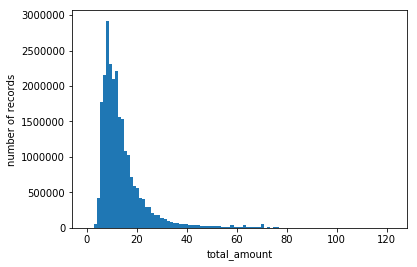

In [11]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

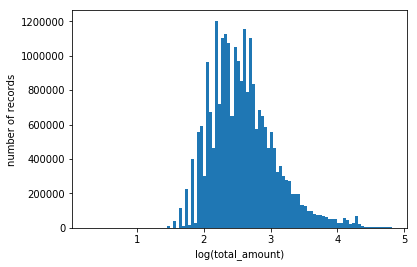

In [12]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()

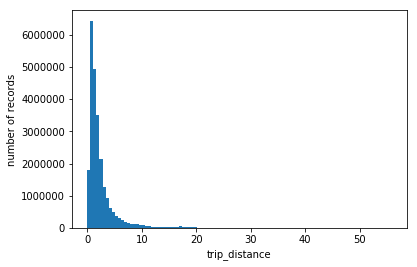

In [13]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

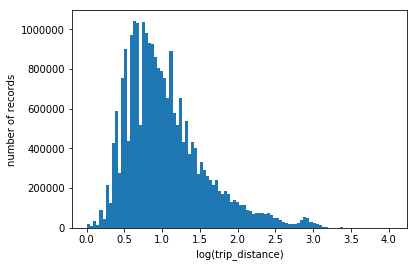

In [14]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()

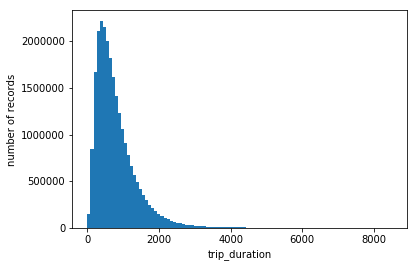

In [15]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

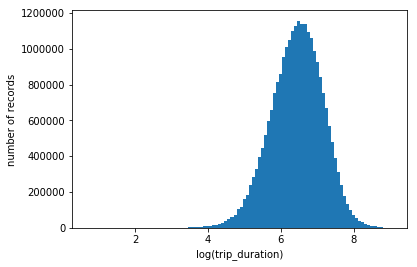

In [16]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()

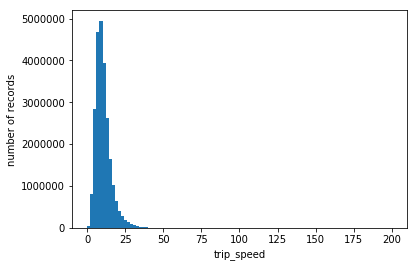

In [17]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

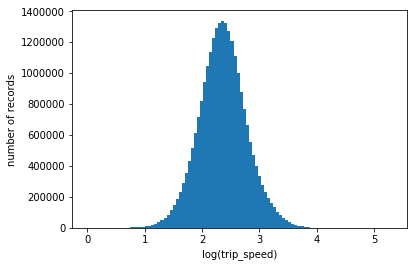

In [18]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()

In [19]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group.head()

,VendorID
PULocationID,
4,57207
12,12621
13,250172
24,83390
41,110770


In [20]:
taxi_zones_shape_requests = nyc_taxi_analyzer.taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests: (69, 8)


In [21]:
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",57207.000
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",12621.000
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",250172.000
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",83390.000
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",110770.000


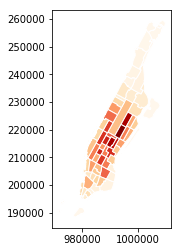

In [22]:
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

## Feature Prepare

We set the `5min_id`, `15min_id` and `30min_id` to represent 5min, 15min and 30min slot. For example, time between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 has a `5min_id` as 0, and time between 2018-01-01 00:05:00 and 2018-01-01 00:10:00 has a `5min_id` as 1, and the similar with `15min_id` and `30min_id`. For each `Xmin_id` (X represents 5, 15 or 30), we predict the requests in all 69 zones. We have some `static features` such as `month`, `day`, `hour`, `weekday`, `is_weekend`, `is_morning_peak`, `is_evening_pick` for all `Xmin_id` and zones. Also we can extend more static features such as weather and zone features. Other `dynamic features` includes requests in `5min ago`, `10min ago`, `15min ago`, `7days ago`, etc. Also we can extend more dynamic features such as total passengers in 5min ago. At last, we generate 34 features for each `Xmin_id` and zone.

In [23]:
all_5min_index, all_5min_static = nyc_taxi_analyzer.get_all_index_and_static(last_5min_id, 'tpep_pickup_5min_id')
all_15min_index, all_15min_static = nyc_taxi_analyzer.get_all_index_and_static(last_15min_id, 'tpep_pickup_15min_id')
all_30min_index, all_30min_static = nyc_taxi_analyzer.get_all_index_and_static(last_30min_id, 'tpep_pickup_30min_id')

all_id: (2424384,) [    0     0     0 ... 35135 35135 35135]
all_LocationID: (2424384,) [  4  12  13 ... 261 262 263]
all_index: (2424384, 0)
tpep_pickup_datetime: 0.9439337253570557
tpep_pickup_month: 1.0396149158477783
tpep_pickup_day: 1.1250901222229004
tpep_pickup_hour: 1.2112553119659424
tpep_pickup_weekday: 1.3095746040344238
is_weekend: 1.9334564208984375
is_morning_peak: 2.611903429031372
is_evening_peak: 3.2762160301208496
all_static: (2424384, 7)
all_id: (808128,) [    0     0     0 ... 11711 11711 11711]
all_LocationID: (808128,) [  4  12  13 ... 261 262 263]
all_index: (808128, 0)
tpep_pickup_datetime: 0.28224802017211914
tpep_pickup_month: 0.3077394962310791
tpep_pickup_day: 0.3323378562927246
tpep_pickup_hour: 0.3569629192352295
tpep_pickup_weekday: 0.3862879276275635
is_weekend: 0.5906002521514893
is_morning_peak: 0.8002297878265381
is_evening_peak: 1.0052990913391113
all_static: (808128, 7)
all_id: (404064,) [   0    0    0 ... 5855 5855 5855]
all_LocationID: (404064,) 

In [24]:
all_5min_index.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [25]:
all_5min_index.tail()

Empty DataFrame
Columns: []
Index: [(35135, 246), (35135, 249), (35135, 261), (35135, 262), (35135, 263)]

In [26]:
all_5min_static.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           3                1   
                    12                          3                1   
                    13                          3                1   
                    24                          3                1   
                    41                          3                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    3   
                    12                         0                    3   
                    13                         0                    3   
                    24                         0                    3   
                    41                         0                    3   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
0                   4                    0                0                0  
                    12                   0                0                0  
                    13                   0                0                0  
                    24                   0                0                0  
                    41                   0                0                0

In [27]:
all_5min_static.tail()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
35135               246                         6               30   
                    249                         6               30   
                    261                         6               30   
                    262                         6               30   
                    263                         6               30   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
35135               246                       23                    5   
                    249                       23                    5   
                    261                       23                    5   
                    262                       23                    5   
                    263                       23                    5   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
35135               246                  1                0                0  
                    249                  1                0                0  
                    261                  1                0                0  
                    262                  1                0                0  
                    263                  1                0                0

In [28]:
def get_sample_group(id_name):
    sample_group = sample_manhattan.groupby([id_name, 'PULocationID'])
    sample_count = sample_group.count()
    sample_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_count:', sample_count.shape)
    sample_mean = sample_group.mean()
    sample_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_mean:', sample_mean.shape)
    sample_sum = sample_group.sum()
    sample_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_sum:', sample_sum.shape)
    sample_dropoff_group = sample_manhattan.groupby([id_name, 'DOLocationID'])
    sample_dropoff_count = sample_dropoff_group.count()
    sample_dropoff_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_count:', sample_dropoff_count.shape)
    sample_dropoff_mean = sample_dropoff_group.mean()
    sample_dropoff_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_mean:', sample_dropoff_mean.shape)
    sample_dropoff_sum = sample_dropoff_group.sum()
    sample_dropoff_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_sum:', sample_dropoff_sum.shape)
    return sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum

In [29]:
sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum = get_sample_group('tpep_pickup_5min_id')
sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum = get_sample_group('tpep_pickup_15min_id')
sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum = get_sample_group('tpep_pickup_30min_id')

sample_count: (1426640, 22)
sample_mean: (1426640, 22)
sample_sum: (1426640, 22)
sample_dropoff_count: (2270057, 22)
sample_dropoff_mean: (2270057, 22)
sample_dropoff_sum: (2270057, 22)
sample_count: (512634, 22)
sample_mean: (512634, 22)
sample_sum: (512634, 22)
sample_dropoff_count: (1013694, 22)
sample_dropoff_mean: (1013694, 22)
sample_dropoff_sum: (1013694, 22)
sample_count: (262914, 22)
sample_mean: (262914, 22)
sample_sum: (262914, 22)
sample_dropoff_count: (606524, 22)
sample_dropoff_mean: (606524, 22)
sample_dropoff_sum: (606524, 22)


In [30]:
sample_5min_count.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,234,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
884.000,107,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
885.000,79,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
890.000,236,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
892.000,170,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [31]:
sample_5min_mean.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,234,2.000,1.000,1.230,1.000,1.000,170.000,1.000,9.000,0.500,0.500,3.090,0.000,0.300,13.390,723.000,6.124,293.000,146.000,2.667,0.802,6.585,1.964
884.000,107,2.000,2.000,1.370,1.000,1.000,79.000,1.000,7.000,0.500,0.500,1.500,0.000,0.300,9.800,411.000,12.000,294.000,147.000,2.380,0.863,6.021,2.565
885.000,79,2.000,2.000,5.050,1.000,1.000,236.000,1.000,17.500,0.500,0.500,3.760,0.000,0.300,22.560,1135.000,16.018,295.000,147.000,3.160,1.800,7.035,2.834
890.000,236,2.000,2.000,2.170,1.000,1.000,170.000,1.000,7.500,0.500,0.500,2.000,0.000,0.300,10.800,276.000,28.304,296.000,148.000,2.468,1.154,5.624,3.378
892.000,170,2.000,2.000,5.660,1.000,1.000,88.000,1.000,19.000,0.500,0.500,4.060,0.000,0.300,24.360,860.000,23.693,297.000,148.000,3.233,1.896,6.758,3.207


In [32]:
sample_5min_sum.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,234,2,1,1.230,1,1,170,1,9.000,0.500,0.500,3.090,0.000,0.300,13.390,723.000,6.124,293.000,146.000,2.667,0.802,6.585,1.964
884.000,107,2,2,1.370,1,1,79,1,7.000,0.500,0.500,1.500,0.000,0.300,9.800,411.000,12.000,294.000,147.000,2.380,0.863,6.021,2.565
885.000,79,2,2,5.050,1,1,236,1,17.500,0.500,0.500,3.760,0.000,0.300,22.560,1135.000,16.018,295.000,147.000,3.160,1.800,7.035,2.834
890.000,236,2,2,2.170,1,1,170,1,7.500,0.500,0.500,2.000,0.000,0.300,10.800,276.000,28.304,296.000,148.000,2.468,1.154,5.624,3.378
892.000,170,2,2,5.660,1,1,88,1,19.000,0.500,0.500,4.060,0.000,0.300,24.360,860.000,23.693,297.000,148.000,3.233,1.896,6.758,3.207


In [33]:
sample_5min_dropoff_count.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,170,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
884.000,79,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
885.000,236,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
890.000,170,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
892.000,88,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [34]:
sample_5min_dropoff_mean.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,170,2.000,1.000,1.230,1.000,1.000,234.000,1.000,9.000,0.500,0.500,3.090,0.000,0.300,13.390,723.000,6.124,293.000,146.000,2.667,0.802,6.585,1.964
884.000,79,2.000,2.000,1.370,1.000,1.000,107.000,1.000,7.000,0.500,0.500,1.500,0.000,0.300,9.800,411.000,12.000,294.000,147.000,2.380,0.863,6.021,2.565
885.000,236,2.000,2.000,5.050,1.000,1.000,79.000,1.000,17.500,0.500,0.500,3.760,0.000,0.300,22.560,1135.000,16.018,295.000,147.000,3.160,1.800,7.035,2.834
890.000,170,2.000,2.000,2.170,1.000,1.000,236.000,1.000,7.500,0.500,0.500,2.000,0.000,0.300,10.800,276.000,28.304,296.000,148.000,2.468,1.154,5.624,3.378
892.000,88,2.000,2.000,5.660,1.000,1.000,170.000,1.000,19.000,0.500,0.500,4.060,0.000,0.300,24.360,860.000,23.693,297.000,148.000,3.233,1.896,6.758,3.207


In [35]:
sample_5min_dropoff_sum.head()

,,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_15min_id,tpep_pickup_30min_id,log_total_amount,log_trip_distance,log_trip_duration,log_trip_speed
tpep_pickup_5min_id,LocationID,,,,,,,,,,,,,,,,,,,,,,
880.000,170,2,1,1.230,1,1,234,1,9.000,0.500,0.500,3.090,0.000,0.300,13.390,723.000,6.124,293.000,146.000,2.667,0.802,6.585,1.964
884.000,79,2,2,1.370,1,1,107,1,7.000,0.500,0.500,1.500,0.000,0.300,9.800,411.000,12.000,294.000,147.000,2.380,0.863,6.021,2.565
885.000,236,2,2,5.050,1,1,79,1,17.500,0.500,0.500,3.760,0.000,0.300,22.560,1135.000,16.018,295.000,147.000,3.160,1.800,7.035,2.834
890.000,170,2,2,2.170,1,1,236,1,7.500,0.500,0.500,2.000,0.000,0.300,10.800,276.000,28.304,296.000,148.000,2.468,1.154,5.624,3.378
892.000,88,2,2,5.660,1,1,170,1,19.000,0.500,0.500,4.060,0.000,0.300,24.360,860.000,23.693,297.000,148.000,3.233,1.896,6.758,3.207


In [36]:
def get_all(all_index, sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum):
    all_count = all_index.join(sample_count, how='left')
    all_count.fillna(0, inplace=True)
    print('all_count:', all_count.shape)
    all_mean = all_index.join(sample_mean, how='left')
    all_mean.fillna(0, inplace=True)
    print('all_mean:', all_mean.shape)
    all_sum = all_index.join(sample_sum, how='left')
    all_sum.fillna(0, inplace=True)
    print('all_sum:', all_sum.shape)
    all_dropoff_count = all_index.join(sample_dropoff_count, how='left')
    all_dropoff_count.fillna(0, inplace=True)
    print('all_dropoff_count:', all_dropoff_count.shape)
    all_dropoff_mean = all_index.join(sample_dropoff_mean, how='left')
    all_dropoff_mean.fillna(0, inplace=True)
    print('all_dropoff_mean:', all_dropoff_mean.shape)
    all_dropoff_sum = all_index.join(sample_dropoff_sum, how='left')
    all_dropoff_sum.fillna(0, inplace=True)
    print('all_dropoff_sum:', all_dropoff_sum.shape)
    all_xmin = all_count.copy()
    all_xmin = all_xmin.join(all_mean, lsuffix='_count', rsuffix='_mean')
    all_xmin = all_xmin.join(all_sum, rsuffix='_sum')
    all_xmin = all_xmin.join(all_dropoff_count, rsuffix='_dropoff_count')
    all_xmin = all_xmin.join(all_dropoff_mean, rsuffix='_dropoff_mean')
    all_xmin = all_xmin.join(all_dropoff_sum, rsuffix='_dropoff_sum')
    print('all_xmin:', all_xmin.shape)
    return all_xmin

In [37]:
all_5min = get_all(all_5min_index, sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum)
all_15min = get_all(all_15min_index, sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum)
all_30min = get_all(all_30min_index, sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum)

all_count: (2424384, 22)
all_mean: (2424384, 22)
all_sum: (2424384, 22)
all_dropoff_count: (2424384, 22)
all_dropoff_mean: (2424384, 22)
all_dropoff_sum: (2424384, 22)
all_xmin: (2424384, 132)
all_count: (808128, 22)
all_mean: (808128, 22)
all_sum: (808128, 22)
all_dropoff_count: (808128, 22)
all_dropoff_mean: (808128, 22)
all_dropoff_sum: (808128, 22)
all_xmin: (808128, 132)
all_count: (404064, 22)
all_mean: (404064, 22)
all_sum: (404064, 22)
all_dropoff_count: (404064, 22)
all_dropoff_mean: (404064, 22)
all_dropoff_sum: (404064, 22)
all_xmin: (404064, 132)


In [38]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                    0.000                  0.000   
                    12                   0.000                  0.000   
                    13                   0.000                  0.000   
                    24                   0.000                  0.000   
                    41                   0.000                  0.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                         0.000             0.000   
                    12                        0.000             0.000   
                    13                        0.000             0.000   
                    24                        0.000             0.000   
                    41                        0.000             0.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                              0.000               0.000   
                    12                             0.000               0.000   
                    13                             0.000               0.000   
                    24                             0.000               0.000   
                    41                             0.000               0.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                        0.000              0.000   
                    12                       0.000              0.000   
                    13                       0.000              0.000   
                    24                       0.000              0.000   
                    41                       0.000              0.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                 0.000          0.000             0.000   
                    12                0.000          0.000             0.000   
                    13                0.000          0.000             0.000   
                    24                0.000          0.000             0.000   
                    41                0.000          0.000             0.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   4                        0.000   
                    12                       0.000   
                    13                       0.000   
                    24                       0.000   
                    41                       0.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   4                                 0.000   
                    12                                0.000   
                    13                                0.000   
                    24                                0.000   
                    41                                0.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   4                        0.000                0.000   
                    12                       0.000                0.000   
                    13                       0.000                0.000   
                    24                       0.000                0.000   
                    41                       0.000                0.000   

                           

In [42]:
def get_all_features(all_xmin, all_static, manhattan_location_num):
    all_xmin_features = all_static.copy()
    all_xmin_features['value'] = all_xmin['VendorID_count']
    all_xmin_features['5min_ago'] = all_xmin['VendorID_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago'] = all_xmin['VendorID_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago'] = all_xmin_features['5min_ago'] + all_xmin_features['5min_10min_ago']
    all_xmin_features['10min_15min_ago'] = all_xmin['VendorID_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago'] = all_xmin_features['10min_ago'] + all_xmin_features['10min_15min_ago']
    all_xmin_features['15min_20min_ago'] = all_xmin['VendorID_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago'] = all_xmin_features['15min_ago'] + all_xmin_features['15min_20min_ago']
    all_xmin_features['20min_25min_ago'] = all_xmin['VendorID_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago'] = all_xmin_features['20min_ago'] + all_xmin_features['20min_25min_ago']
    all_xmin_features['25min_30min_ago'] = all_xmin['VendorID_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago'] = all_xmin_features['25min_ago'] + all_xmin_features['25min_30min_ago']
    all_xmin_features['5min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago_drop'] = all_xmin_features['5min_ago_drop'] + all_xmin_features['5min_10min_ago_drop']
    all_xmin_features['10min_15min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago_drop'] = all_xmin_features['10min_ago_drop'] + all_xmin_features['10min_15min_ago_drop']
    all_xmin_features['15min_20min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago_drop'] = all_xmin_features['15min_ago_drop'] + all_xmin_features['15min_20min_ago_drop']
    all_xmin_features['20min_25min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago_drop'] = all_xmin_features['20min_ago_drop'] + all_xmin_features['20min_25min_ago_drop']
    all_xmin_features['25min_30min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago_drop'] = all_xmin_features['25min_ago_drop'] + all_xmin_features['25min_30min_ago_drop']
    all_xmin_features['1day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24)
    all_xmin_features['7day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*7)
    all_xmin_features['14day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*14)
    all_xmin_features['21day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*21)
    all_xmin_features['28day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*28)
    all_xmin_features.fillna(0, inplace=True)
    print('all_xmin_features:', all_xmin_features.shape)
    return all_xmin_features

In [43]:
all_5min_features = get_all_features(all_5min, all_5min_static, nyc_taxi_analyzer.manhattan_location_num)
all_15min_features = get_all_features(all_15min, all_15min_static, nyc_taxi_analyzer.manhattan_location_num)
all_30min_features = get_all_features(all_30min, all_30min_static, nyc_taxi_analyzer.manhattan_location_num)

all_xmin_features: (2424384, 35)
all_xmin_features: (808128, 35)
all_xmin_features: (404064, 35)


In [44]:
all_5min_features.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           3                1   
                    12                          3                1   
                    13                          3                1   
                    24                          3                1   
                    41                          3                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    3   
                    12                         0                    3   
                    13                         0                    3   
                    24                         0                    3   
                    41                         0                    3   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           0.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          0.000     0.000           0.000      0.000   
                    24          0.000     0.000           0.000      0.000   
                    41          0.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

## Train and Validate

We split all data into train and validate part. We demonstrate 4 methods to forecast requests: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE). We also visualize the prediction results between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 using `geopandas` (the darker the color, the more demand), and we can visualize any time slot using this method.

In [ ]:
manhattan_location_num = 

train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_15min = all_15min_features[:int(train_valid_split_15min_id)*manhattan_location_num]
print('train_X_15min:', train_X_15min.shape)
valid_X_15min = all_15min_features[int(train_valid_split_15min_id)*manhattan_location_num:int(last_15min_id)*manhattan_location_num]
print('valid_X_15min:', valid_X_15min.shape)
train_Y_15min = train_X_15min['value'].values
print('train_Y_15min:', len(train_Y_15min))
valid_Y_15min = valid_X_15min['value'].values
print('valid_Y_15min:', len(valid_Y_15min))

train_X_30min = all_30min_features[:int(train_valid_split_30min_id)*manhattan_location_num]
print('train_X_30min:', train_X_30min.shape)
valid_X_30min = all_30min_features[int(train_valid_split_30min_id)*manhattan_location_num:int(last_30min_id)*manhattan_location_num]
print('valid_X_30min:', valid_X_30min.shape)
train_Y_30min = train_X_30min['value'].values
print('train_Y_30min:', len(train_Y_30min))
valid_Y_30min = valid_X_30min['value'].values
print('valid_Y_30min:', len(valid_Y_30min))

In [ ]:
pickle.dump((train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min), open('train_valid_5min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min), open('train_valid_15min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min), open('train_valid_30min.pickle', 'wb'), protocol=2)

In [ ]:
train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min = pickle.load(open('train_valid_5min.pickle', 'rb'))
train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min = pickle.load(open('train_valid_15min.pickle', 'rb'))
train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min = pickle.load(open('train_valid_30min.pickle', 'rb'))

In [ ]:
train_X_5min.head()

In [ ]:
train_X_5min.describe()

In [ ]:
valid_X_5min.head()

In [ ]:
valid_X_5min.describe()

In [ ]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [ ]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [ ]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [ ]:
# Add new prediction algorithm or change parameters of above 4 prediction algorithms [Challenge Question]
def new_algo_train_validate(train_X, train_Y, test_X, test_Y):
    """
    :param train_X : Dataframe, (?, 35) train data including 'value' column, you should drop the column first (already done)
    :param train_Y: array, train label data, which is actually train_X['value'].values
    :param test_X : Dataframe, (?, 35) test data including 'value' column, you should drop the column first (already done)
    :param test_Y: array, test label data, which is actually test_X['value'].values
    :return: array, test prediction data
    """
    train_X = train_X.drop('value', axis=1)
    test_X = test_X.drop('value', axis=1)
    pred = np.array([0 for _ in test_Y])
    
    # TODO implement your prediction algorithm here
    
    
    return pred

pred_30min_new_algo = new_algo_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_new_algo_mae = mae(valid_Y_30min, pred_30min_new_algo)
print('valid_30min_new_algo_mae:', valid_30min_new_algo_mae)

In [ ]:
# train and validate 5min slot
pred_5min_xgb = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_xgb_mae = mae(valid_Y_5min, pred_5min_xgb)
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
pred_5min_lr = lr_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lr_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#pred_5min_tf = tf_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
#valid_5min_tf_mae = mae(valid_Y_5min, pred_5min_tf)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
pred_5min_lgb = lgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lgb_mae = mae(valid_Y_5min, pred_5min_lgb)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred_xgb'] = pred_5min_xgb
valid_pred_5min['pred_lr'] = pred_5min_lr
#valid_pred_5min['pred_tf'] = pred_5min_tf
valid_pred_5min['pred_lgb'] = pred_5min_lgb
print('valid_pred_5min:', valid_pred_5min.shape)
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)
valid_pred_5min.to_csv('valid_pred_5min.csv', index=False)

In [ ]:
# train and validate 15min slot
pred_15min_xgb = xgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_xgb_mae = mae(valid_Y_15min, pred_15min_xgb)
print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
pred_15min_lr = lr_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lr_mae = mae(valid_Y_15min, pred_15min_lr)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#pred_15min_tf = tf_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
#valid_15min_tf_mae = mae(valid_Y_15min, pred_15min_tf)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
pred_15min_lgb = lgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lgb_mae = mae(valid_Y_15min, pred_15min_lgb)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)
valid_pred_15min = pd.DataFrame(valid_X_15min, columns=['value'])
valid_pred_15min.reset_index(inplace=True)
valid_pred_15min['pred_xgb'] = pred_15min_xgb
valid_pred_15min['pred_lr'] = pred_15min_lr
#valid_pred_15min['pred_tf'] = pred_15min_tf
valid_pred_15min['pred_lgb'] = pred_15min_lgb
print('valid_pred_15min:', valid_pred_15min.shape)
train_X_15min.to_csv('train_X_15min.csv', index=True)
valid_X_15min.to_csv('valid_X_15min.csv', index=True)
valid_pred_15min.to_csv('valid_pred_15min.csv', index=False)

In [ ]:
# train and validate 30min slot
pred_30min_xgb = xgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_xgb_mae = mae(valid_Y_30min, pred_30min_xgb)
print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
pred_30min_lr = lr_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lr_mae = mae(valid_Y_30min, pred_30min_lr)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#pred_30min_tf = tf_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
#valid_30min_tf_mae = mae(valid_Y_30min, pred_30min_tf)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
pred_30min_lgb = lgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lgb_mae = mae(valid_Y_30min, pred_30min_lgb)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)
valid_pred_30min = pd.DataFrame(valid_X_30min, columns=['value'])
valid_pred_30min.reset_index(inplace=True)
valid_pred_30min['pred_xgb'] = pred_30min_xgb
valid_pred_30min['pred_lr'] = pred_30min_lr
#valid_pred_30min['pred_tf'] = pred_30min_tf
valid_pred_30min['pred_lgb'] = pred_30min_lgb
print('valid_pred_30min:', valid_pred_30min.shape)
train_X_30min.to_csv('train_X_30min.csv', index=True)
valid_X_30min.to_csv('valid_X_30min.csv', index=True)
valid_pred_30min.to_csv('valid_pred_30min.csv', index=False)

In [ ]:
valid_pred_5min.head()

In [ ]:
for group_name, group_data in valid_pred_5min.groupby(['tpep_pickup_5min_id']):
    print('group_name:', group_name)
    valid_pred_5min_group = group_data.groupby(['LocationID']).sum()[['value', 'pred_xgb', 'pred_lr', 'pred_lgb']]  # , 'pred_tf'
    taxi_zones_shape_requests_pred_5min = taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
    taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
    taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_xgb', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lr', cmap='OrRd', edgecolor='white')
    #taxi_zones_shape_requests_pred_5min.plot(column='pred_tf', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lgb', cmap='OrRd', edgecolor='white')

    break

In [ ]:
valid_pred_5min_group

In [ ]:
# show evaluate result
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)

print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)

print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)

## Conclusion

The validate results show that XGBoost performs better than other algorithms. We can improve the results by adding more features and carefully tuning the parameters of the algorithm.